In [22]:
import pennylane as qml
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from math import log, ceil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [23]:
dataset = Planetoid("/tmp/Cora", "Cora", split="random", num_train_per_class=int(140/7))
(
    dataset.train_mask.sum().item(),
    dataset.val_mask.sum().item(),
    dataset.test_mask.sum().item()
)

(140, 500, 1000)

In [24]:
n = ceil(log(dataset.num_features)/log(2))
n

11

In [25]:
n_out = dataset.num_classes
n_out

7

In [26]:
dev = qml.device("default.qubit", wires=n)

In [27]:
@qml.qnode(dev, interface="torch")
def circuit(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n), pad_with=0.001, normalize=True)
    qml.StronglyEntanglingLayers(weights=weights, wires=range(n))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_out)]

In [46]:
# def single(layer, x):
#     return layer(x)

class QNNModel(torch.nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        
        self.q_layer_1 = qml.qnn.TorchLayer(circuit, {
            "weights": (n_layers, n, 3)
        })

    def single(self, x):
        return self.q_layer_1(x)
    
    def forward(self, x):
        # x = torch.zeros(x.shape[0], n_out)
        x = self.q_layer_1(x)
        
        # with mp.Pool() as p:
        #     res = [p.apply_async(single, args=(self.q_layer_1, x)) for x in data.x]
        #     for i in tqdm(range(data.x.shape[0])):
        #         out[i] = res[i].get()
            
        return x

In [15]:
class ClassicModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer = torch.nn.Linear(dataset.num_features, dataset.num_classes)

    def forward(self, x):
        x = self.layer(x)
        return x

In [135]:
device = "cpu" # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QNNModel(3).to(device)
# model = ClassicModel().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [136]:
losses = []

model.train()
for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    out = model(data.x[data.train_mask])
    loss = F.nll_loss(out, data.y[data.train_mask])
    loss.backward()
    losses.append(loss.detach())
    optimizer.step()

100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


In [137]:
model.eval()
pred = model(data.x[data.test_mask]).argmax(dim=1)
correct = (pred == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1840


In [132]:
logits = model(data.x[data.train_mask])
logits

tensor([[ 2.6582e-02, -2.1774e-02,  3.2051e-03,  2.5405e-02,  2.0161e-02,
         -2.7122e-02, -5.5848e-03],
        [-3.2759e-02, -1.4809e-03, -1.3429e-02,  2.1579e-02,  5.7676e-03,
         -6.4986e-03,  1.1810e-02],
        [-5.1531e-02,  3.8589e-03,  2.3539e-02,  1.5666e-02,  3.4829e-02,
          1.5287e-02, -2.0084e-02],
        [ 1.3137e-03,  5.3849e-03, -2.7352e-02,  1.8210e-02, -1.3130e-02,
         -1.2610e-02,  2.4850e-03],
        [-7.2420e-03, -2.4225e-03, -2.5376e-02, -3.5187e-03, -1.0344e-02,
         -2.4037e-02,  4.5793e-02],
        [-7.0797e-03,  8.9204e-03, -2.0440e-02, -2.2538e-02, -2.5399e-02,
          1.0036e-02, -1.2509e-02],
        [ 9.4537e-03,  3.5388e-02, -4.2877e-03,  1.8536e-03,  2.1698e-02,
         -2.5939e-02,  5.6412e-02],
        [-4.7975e-02,  5.7970e-02,  4.9904e-03,  1.2816e-02, -1.1772e-03,
         -1.1068e-02,  5.2979e-03],
        [ 7.4035e-02, -7.4917e-03, -2.2295e-02,  4.7267e-04, -3.8066e-03,
          3.3790e-02, -1.7022e-02],
        [ 

In [133]:
logits.argmax(dim=1)

tensor([0, 3, 4, 3, 6, 5, 6, 1, 0, 1, 6, 5, 0, 4, 0, 3, 0, 1, 5, 3, 3, 4, 4, 6,
        6, 2, 5, 4, 2, 3, 6, 5, 1, 3, 5, 0, 0, 5, 3, 1, 3, 5, 1, 4, 2, 1, 3, 5,
        3, 1, 4, 2, 5, 2, 3, 1, 4, 0, 6, 2, 1, 6, 3, 5, 4, 0, 4, 6, 3, 4, 3, 3,
        1, 6, 2, 6, 3, 3, 3, 6, 1, 4, 0, 6, 3, 2, 3, 6, 4, 3, 2, 1, 2, 1, 2, 0,
        2, 1, 5, 4, 0, 1, 5, 1, 2, 3, 5, 0, 6, 3, 0, 5, 4, 6, 5, 0, 6, 3, 6, 1,
        5, 0, 0, 3, 5, 2, 5, 3, 4, 3, 1, 2, 6, 2, 4, 4, 1, 2, 6, 5])

In [134]:
(data.y[data.train_mask] == logits.argmax(dim=1)).sum() / data.train_mask.sum()

tensor(0.3500)

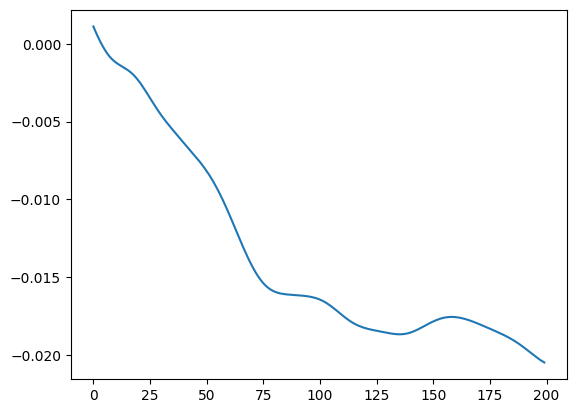

In [131]:
plt.plot(losses)